```
This software is a part of GPU Ocean.

Copyright (C) 2019  SINTEF Digital

In this notebook we will load the true state, and simply take a look
on the data we got.

This program is free software: you can redistribute it and/or modify
it under the terms of the GNU General Public License as published by
the Free Software Foundation, either version 3 of the License, or
(at your option) any later version.

This program is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
GNU General Public License for more details.

You should have received a copy of the GNU General Public License
along with this program.  If not, see <http://www.gnu.org/licenses/>.
```

# Investigating the ensemble initial conditions

In this notebook we will load the ensemble initial conditions, and simply take a look on the data we got.

## Set environment

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from matplotlib import animation, rc

import pycuda.driver as cuda
import os
import sys
import datetime

from importlib import reload
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '../../')))

#Set large figure sizes
rc('figure', figsize=(16.0, 12.0))
rc('animation', html='html5')

#Import our simulator
from SWESimulators import IPythonMagic, SimReader, Observation

In [2]:
%cuda_context_handler gpu_ctx

In [3]:
#Create output directory for images
#imgdir = 'double_jet'
#filename_prefix = imgdir + "/" + datetime.datetime.now().strftime("%Y_%m_%d-%H_%M_%S") + "_"
#os.makedirs(imgdir, exist_ok=True)
#print("Saving images to " + imgdir)

# The data

The data used for this paper is available for download from [the GPU Ocean server](http://gpu-ocean.met.no:9000/gpu_ocean/DAPaper/).

Please start with downloading the files `double_jet_ensemble_init.zip` and `double_jet_truth.zip` to this folder, and unzip them so that the following lines of code passes:

In [4]:
ensemble_init_path = os.path.abspath('double_jet_ensemble_init/')
assert len(os.listdir(ensemble_init_path)) == 102, "Ensemble init folder has wrong number of files"

truth_path = os.path.abspath('double_jet_truth/')
assert len(os.listdir(truth_path)) == 4, "Truth folder has wrong number of files"

### Define functions for plotting

In [22]:
def imshow(im, interpolation="None", title=None, figsize=(4,4), interior=False):
    fig = plt.figure(figsize=figsize)
    
    if interior:
        im = plt.imshow(im[2:-2,2:-2], interpolation=interpolation, origin='lower')
    else:
        im = plt.imshow(im, interpolation=interpolation, origin='lower')
    
    plt.colorbar()
    if title is not None:
        plt.title(title)
        
def imshow3(eta, hu, hv, interpolation="None", title=None, figsize=(12,3), 
            interior=False, color_bar_from_zero=False):
    fig, axs = plt.subplots(1,3, figsize=figsize)
    
    eta_max = np.max(np.abs(eta))
    huv_max = max(np.max(np.abs(hu)), np.max(np.abs(hv)))
    eta_min = -eta_max
    huv_min = -huv_max
    if color_bar_from_zero:
        eta_min, huv_min = 0, 0
    
    if interior:
        eta_im = axs[0].imshow(eta[2:-2,2:-2], interpolation=interpolation, origin='lower', vmin=eta_min, vmax=eta_max)
    else:
        eta_im = axs[0].imshow(eta, interpolation=interpolation, origin='lower', vmin=eta_min, vmax=eta_max)
    axs[0].set_title("$\eta$")
    plt.colorbar(eta_im, ax=axs[0])
    
    if interior:
        hu_im = axs[1].imshow(hu[2:-2,2:-2], interpolation=interpolation, origin='lower', vmin=huv_min, vmax=huv_max)
    else:
        hu_im = axs[1].imshow(hu, interpolation=interpolation, origin='lower', vmin=huv_min, vmax=huv_max)
    axs[1].set_title("$hu$")
    plt.colorbar(hu_im, ax=axs[1])

    if interior:
        hv_im = axs[2].imshow(hv[2:-2,2:-2], interpolation=interpolation, origin='lower', vmin=huv_min, vmax=huv_max)
    else:
        hv_im = axs[2].imshow(hv, interpolation=interpolation, origin='lower', vmin=huv_min, vmax=huv_max)
    axs[2].set_title("$hv$")
    plt.colorbar(hv_im, ax=axs[2])

    if title is not None:
        plt.suptitle(title)
    plt.tight_layout()
    
def plotDrifters(observations, sim_reader, t, drifter_set=[]):
    drifter_positions = observations.get_drifter_position(t)

    fig = plt.figure(figsize=(7,7))
    ax = plt.subplot(111)
    nx, ny = sim_reader.get('nx'), sim_reader.get('ny')
    dx, dy = sim_reader.get('dx'), sim_reader.get('dy')

    emptyData =np.ma.masked_where(np.zeros((ny,nx)) > 1, np.zeros((ny,nx)))
    ax.imshow(emptyData, origin="lower", extent=[0, nx*dx, 0, ny*dy], cmap='binary')

    for i in range(drifter_positions.shape[0]):
        color = 'xkcd:pale cyan'
        if i in drifter_set:
            color = 'xkcd:tomato red'
        circ_end = matplotlib.patches.Circle((drifter_positions[i,0], drifter_positions[i,1]),
                                             3000, fill=True, zorder=10, color=color)
        ax.add_patch(circ_end)

    
def days_to_sec(days):
    return days*24*60*60

def truth_time_step(t):
    t = t - days_to_sec(3)
    return int(t/(60*60))

# Read initial conditions and mean and variance 

Reading files...

In [15]:
truth_state_filename = os.path.join(truth_path, "double_jet_case_truth.nc")
observations_filename = os.path.join(truth_path, "drifter_observations.pickle")

ensemble_init_file_name = os.path.join(ensemble_init_path, "double_jet_case_XX.nc")
num_files = 100
sim_readers = [None]*num_files
for i in range(num_files):
    sim_readers[i] = SimReader.SimNetCDFReader(ensemble_init_file_name.replace('XX', str(i).zfill(2)))

Get mean...

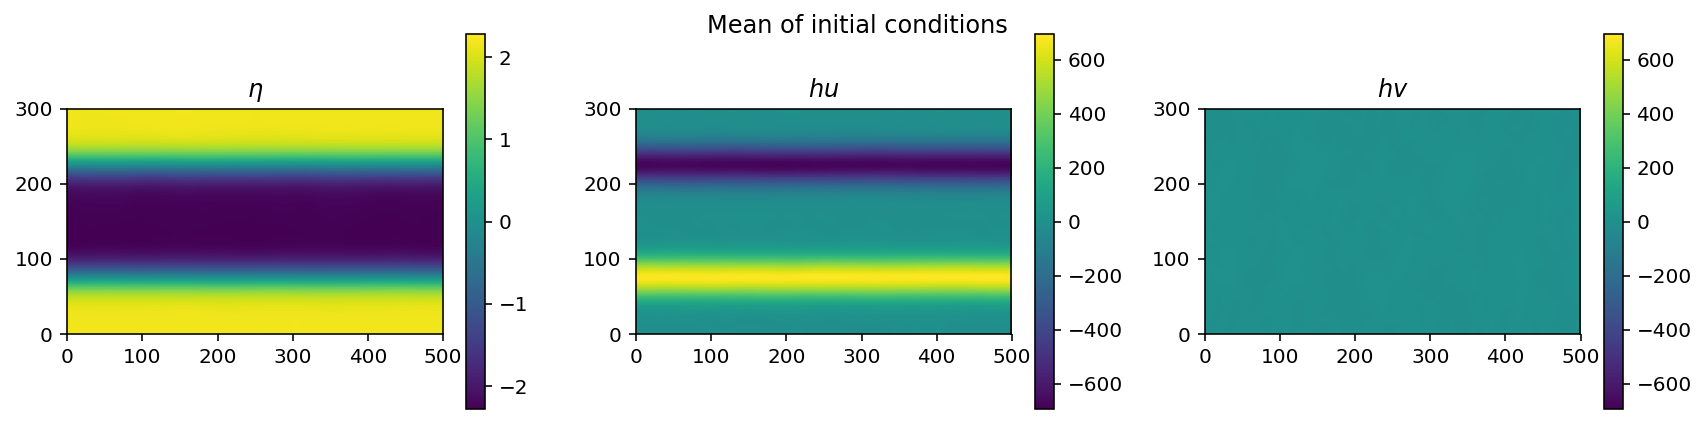

In [26]:
mean_eta, mean_hu, mean_hv, tmp_t = sim_readers[0].getLastTimeStep()
for i in range(1,num_files):
    tmp_eta, tmp_hu, tmp_hv, tmp_t = sim_readers[i].getLastTimeStep()
    mean_eta += tmp_eta
    mean_hu += tmp_hu
    mean_hv += tmp_hv
mean_eta /= num_files
mean_hu  /= num_files
mean_hv  /= num_files
imshow3(mean_eta, mean_hu, mean_hv, title='Mean of initial conditions')

Get variance

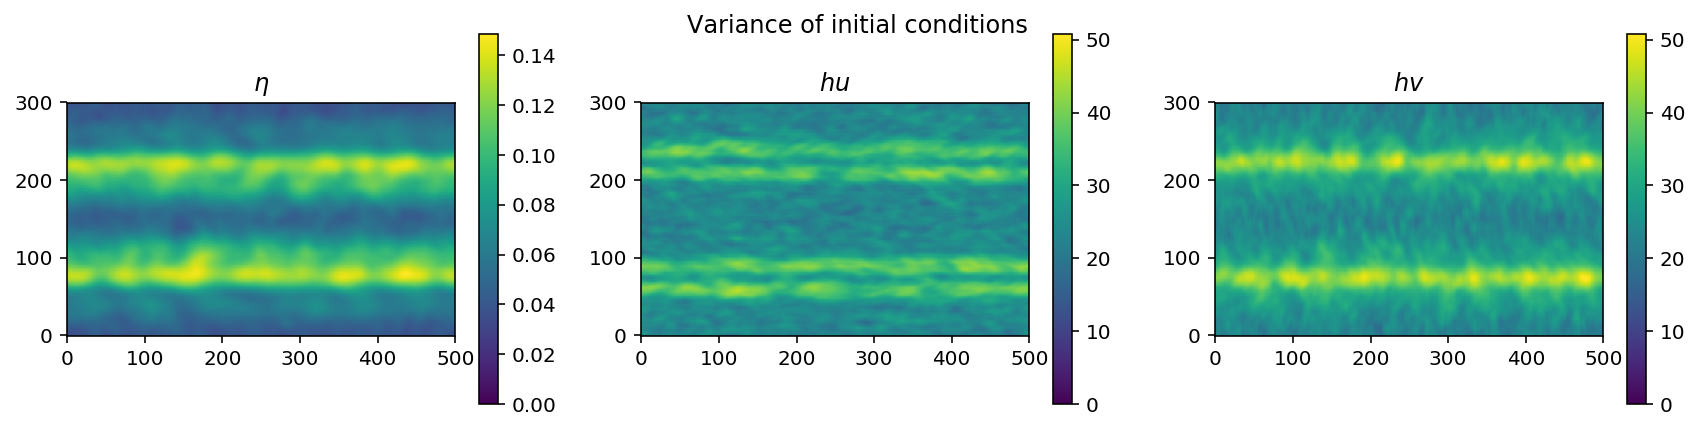

In [25]:
var_eta, var_hu, var_hv = np.zeros_like(mean_eta), np.zeros_like(mean_hu), np.zeros_like(mean_hv)
for sim_reader in sim_readers:
    tmp_eta, tmp_hu, tmp_hv, tmp_t = sim_reader.getLastTimeStep()
    var_eta += (tmp_eta - mean_eta)**2
    var_hu  += (tmp_hu  - mean_hu )**2
    var_hv  += (tmp_hv  - mean_hv )**2
var_eta = np.sqrt(var_eta/(num_files-1))
var_hu  = np.sqrt(var_hu /(num_files-1))
var_hv  = np.sqrt(var_hv /(num_files-1))

imshow3(var_eta, var_hu, var_hv, color_bar_from_zero=True, title='Variance of initial conditions')